# French Cam-CAN using behavioral data sets

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks', palette='tab10')

from sklearn.preprocessing import Imputer
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.externals.joblib import Memory, Parallel, delayed

from camcan.datasets import load_camcan_behavioural
from camcan.datasets import load_camcan_behavioural_feature

In [56]:
path_data = '/home/glemaitre/Documents/data/camcan/cc700-scored/total_score.csv'
path_participants_info = '/home/glemaitre/Documents/data/camcan/cc700-scored/participant_data.csv'
path_selected_features = "/home/glemaitre/Documents/data/camcan/cc700-scored/features"
path_exp_feat_map = '/home/glemaitre/Documents/data/camcan/cc700-scored/behavioural_features.json'

### Age prediction using key variables

#### Baseline model using ridge regressor

This step make age prediction using key variables stated in:

Taylor, Jason R., et al. "The Cambridge Centre for Ageing and Neuroscience (Cam-CAN) data repository: structural and functional MRI, MEG, and cognitive data from a cross-sectional adult lifespan sample." Neuroimage (2015).

In [57]:
# load the interesting features
features_name = ['Observations']
with open(path_selected_features, mode="rt", encoding="utf-8") as f:
    for row in f:
        features_name.append(row.strip())

dataset = load_camcan_behavioural(path_data, path_participants_info, column_selected=features_name)

X = dataset.data
y = dataset.scores.age

print('There is {} selected features'.format(X.shape[1]))

There is 113 selected features


There is some missing data inside these features and they will be replace by a mean value.
In addition, we will first use a ridge regressor as a baseline estimator.

In [60]:
def plot_results(y_true, y_pred, method):
    f = plt.figure(figsize=(6, 6))
    ax = f.gca()
    ax.scatter(y_true, y_pred)
    ax.plot([0, 100], [0, 100], 'r', linewidth=2)
    ax.grid(linestyle='--')
    xlabels = ['%u' % x for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels, fontsize=26)
    labels = ['%u' % x for x in ax.get_yticks()]
    ax.set_yticklabels(labels, fontsize=26)
    ax.set_ylabel('Predicted Age', fontsize=24)
    ax.set_xlabel('True Age', fontsize=24)
    ax.text(0, 90, r'$R^2$=%.2f, MAE=%.2f' % (r2_score(y_true, y_pred), median_absolute_error(y_true, y_pred)),
            fontsize=18)
    ax.set_title(method,
                 fontsize=20, fontweight='bold')
    f.tight_layout()

R2 score: 0.6330533696801592
Median absolute deviation score: 7.022467141220083


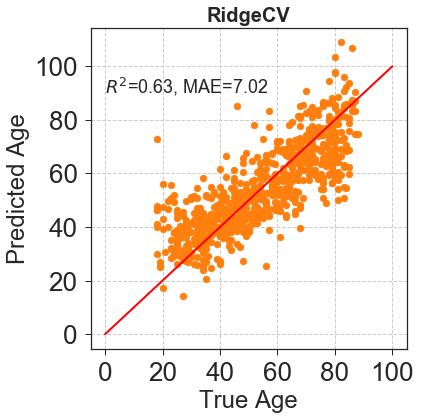

In [61]:
pipeline = make_pipeline(Imputer(), RidgeCV())
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'RidgeCV')

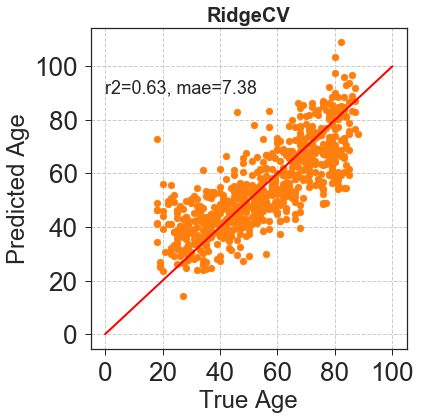

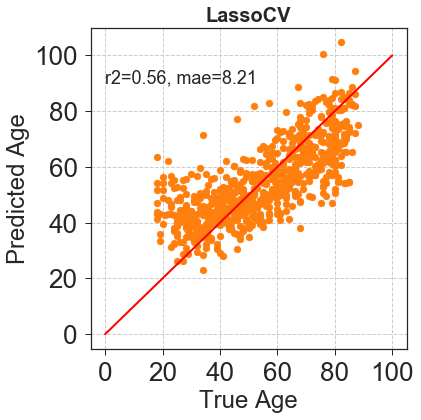

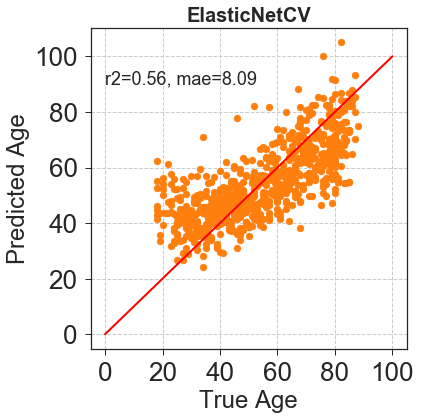

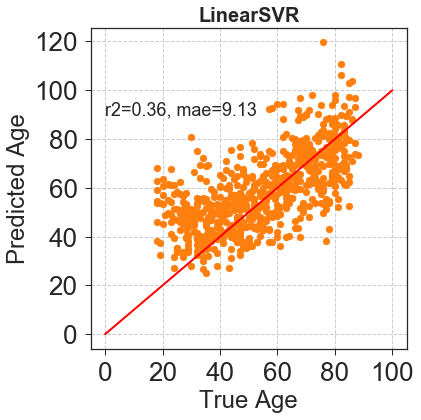

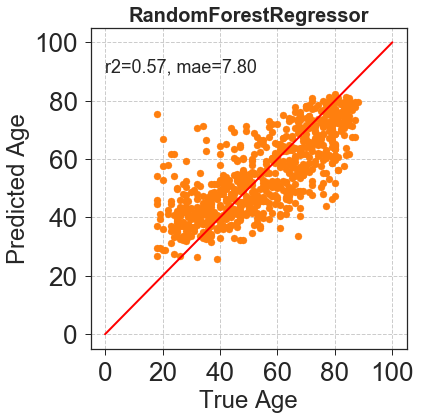

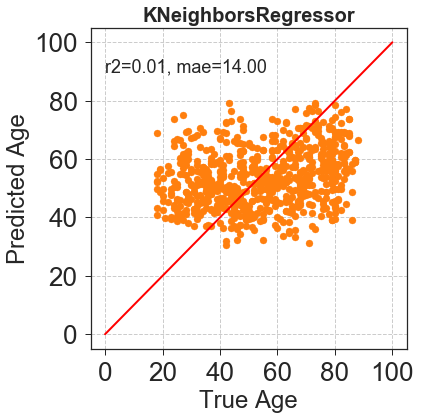

In [38]:
cv = KFold(shuffle=True, random_state=0)
estimators = [RidgeCV(cv=cv),
              LassoCV(cv=cv, random_state=0),
              ElasticNetCV(cv=cv, random_state=0),
              LinearSVR(random_state=0),
              RandomForestRegressor(random_state=0),
              KNeighborsRegressor()]

for estimator in estimators:
    pipeline = make_pipeline(Imputer(), estimator)
    y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True, random_state=0))
    plot_results(y, y_pred, estimator.__class__.__name__)

### Age prediction using univariate feature selection

Load all the data and remove the data link to "HomeInterview" which contain data directly link to the age. In addition, we will keep only numeric features which are non-constant.

In [157]:
dataset = load_camcan_behavioural(path_data, path_participants_info)
X = dataset.data
y = np.array(dataset.scores.age)

# remove home interview
experiment_feature_to_exclude = load_camcan_behavioural_feature(path_exp_feat_map, "HomeInterview")
X = X.drop(list(experiment_feature_to_exclude), axis=1)

# retain only numeric data
X = X.select_dtypes(include=[np.number])
column_names = X.columns
X = Imputer().fit_transform(X)
# remove constant feature
non_contant_feature = np.ones((X.shape[1], ), dtype=bool)
constant_feature = [16, 17, 18, 43, 44, 69, 70, 95, 96, 121, 122, 367, 381, 382, 383, 406, 422, 477,
478, 479, 480, 481, 499, 500, 502, 503, 508, 534, 536, 537, 556, 557, 572, 573, 574, 575,
576, 578, 579, 580, 581, 582, 583, 585, 586, 587, 588, 589, 590, 591, 595, 596, 597, 599,
600, 601, 602, 603, 604]
non_contant_feature[constant_feature] = False
X = X[:, non_contant_feature]
# keep track of the column name to know which feature will be selected
column_names = column_names[non_contant_feature]

Different number of feature will be selected and each time a model will be fitted.
We will repeat 10 times this experiment.

In [69]:
def fit_predict_estimator(pipeline, X, y, k, random_state):
    pipeline.set_params(selectkbest__k=k)
    y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True, random_state=random_state))
    return (r2_score(y, y_pred), median_absolute_error(y, y_pred))

In [ ]:
memory = Memory(cachedir='/home/glemaitre/cache', verbose=0)

cv = KFold(shuffle=True, random_state=0)
estimators = [RidgeCV(cv=cv),
              LassoCV(cv=cv, random_state=0),
              ElasticNetCV(cv=cv, random_state=0),
              RandomForestRegressor(random_state=0, n_estimators=50)]

n_features_range = (10, X.shape[1], 5)

results = []
for n_try in range(10):
    # initialisation for the dictionary
    results_try = {}
    for estimator in estimators:
        results_try[estimator.__class__.__name__] = []
    for estimator in estimators:
        pipeline = Pipeline(memory=memory,
                            steps=[('selectkbest', SelectKBest(f_regression, k=10)),
                                   ('clf', estimator)])
        results_try[estimator.__class__.__name__] += Parallel(n_jobs=-1)(delayed(fit_predict_estimator)
                                                                         (pipeline, X, y, k, n_try) 
                                                                          for k in np.arange(n_features_range[0],
                                                                                             n_features_range[1],
                                                                                             n_features_range[2],
                                                                                             dtype=int))
    results += tuple([results_try])

Compute the mean and standard deviation through the different try

In [96]:
mean_r2 = {}
mean_mae = {}
std_r2 = {}
std_mae = {}

for estimator in estimators:
    mean_r2[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))
    mean_mae[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))
    std_r2[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))
    std_mae[estimator.__class__.__name__] = np.zeros((len(results),
                                                      len(results[0][estimator.__class__.__name__])))

for n_try in range(len(results)):
    for estimator in estimators:
        for i in range(len(results[n_try][estimator.__class__.__name__])):
            mean_r2[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][0]
            mean_mae[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][1]
            std_r2[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][0]
            std_mae[estimator.__class__.__name__][n_try, i] = results[n_try][estimator.__class__.__name__][i][1]

for estimator in estimators:
    mean_r2[estimator.__class__.__name__] = np.mean(mean_r2[estimator.__class__.__name__], axis=0)
    mean_mae[estimator.__class__.__name__] = np.mean(mean_mae[estimator.__class__.__name__], axis=0)
    std_r2[estimator.__class__.__name__] = np.std(std_r2[estimator.__class__.__name__], axis=0)
    std_mae[estimator.__class__.__name__] = np.std(std_mae[estimator.__class__.__name__], axis=0)

For each estimator we can plot the evolution of the different scores in function of the number of features

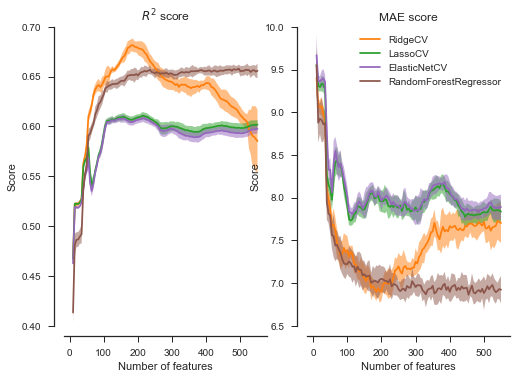

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2)
for estimator in estimators:
    estimator_name = estimator.__class__.__name__
    k = np.arange(n_features_range[0], n_features_range[1], n_features_range[2], dtype=int)
    
    ax1.plot(k, mean_r2[estimator_name], label=estimator_name)
    ax1.fill_between(k, mean_r2[estimator_name] + std_r2[estimator_name],
                    mean_r2[estimator_name] - std_r2[estimator_name], alpha=0.5)
    ax1.set_title(r'$R^2$ score')
    ax1.set_xlabel('Number of features')
    ax1.set_ylabel('Score')
    
    ax2.plot(k, mean_mae[estimator_name], label=estimator_name)
    ax2.fill_between(k, mean_mae[estimator_name] + std_mae[estimator_name],
                    mean_mae[estimator_name] - std_mae[estimator_name], alpha=0.5)
    ax2.set_title('MAE score')
    ax2.set_xlabel('Number of features')
    ax2.set_ylabel('Score')
    ax2.legend()
    
    sns.despine(offset=10)
    ax1.set_ylim([0.4, 0.7])
    ax2.set_ylim([6.5, 10.])

In [126]:
k = np.arange(n_features_range[0], n_features_range[1], n_features_range[2], dtype=int)
print('Maximum R2 with Ridge using {} feature'.format(k[mean_r2['RidgeCV'].argmax()]))
print('Maximum R2 with Random Forest using {} feature'.format(k[mean_r2['RandomForestRegressor'].argmax()]))

print('Maximum MAE with Ridge using {} feature'.format(k[mean_mae['RidgeCV'].argmin()]))
print('Maximum MAE with Random Forest using {} feature'.format(k[mean_mae['RandomForestRegressor'].argmin()]))

Maximum R2 with Ridge using 185 feature
Maximum R2 with Random Forest using 495 feature
Maximum MAE with Ridge using 185 feature
Maximum MAE with Random Forest using 455 feature


##### Analysis

The best performance can be reached with 185 features. After this point, Ridge performance are deacreasing and the performance of Random Forest are stable. It means that the trees are probably not using any of the additional features added. The next experiments: (i) check what are these 185 features and (ii) check a selection on feature based on features importance when using the Random Forest.

R2 score: 0.6872499128007612
Median absolute deviation score: 6.98629643562785


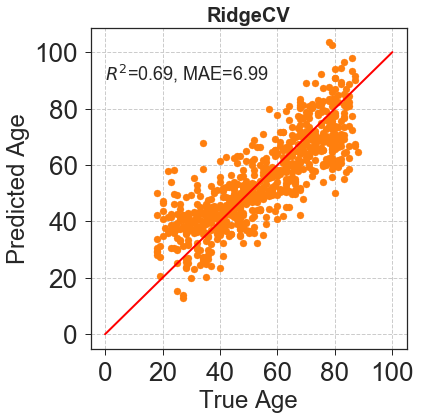

In [129]:
pipeline = make_pipeline(SelectKBest(f_regression, k=185), RidgeCV())
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'RidgeCV')

#### Analysis of the selected features

In [141]:
feature_selected_idx = np.zeros(X.shape[1])
kf = KFold(n_splits=10, random_state=0, shuffle=True)
for train_index, _ in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    selector = SelectKBest(f_regression, k=185)
    selector.fit(X_train, y_train)
    feature_selected_idx[selector.get_support()] += 1

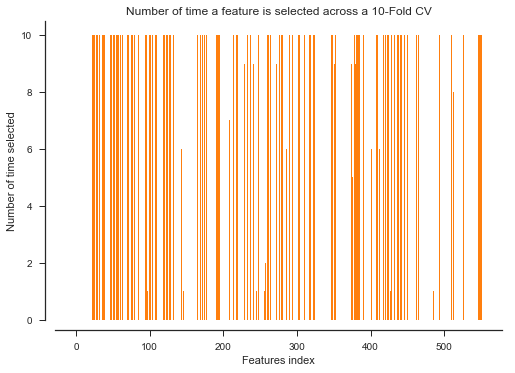

In [145]:
plt.bar(range(X.shape[1]), feature_selected_idx)
plt.xlabel('Features index')
plt.ylabel('Number of time selected')
plt.title('Number of time a feature is selected across a 10-Fold CV')
sns.despine(offset=10)

In [150]:
final_features_idx = feature_selected_idx > 5
print('{} selected features'.format(np.count_nonzero(final_features_idx)))

186 selected features


In [152]:
print('The selected columns are: \n {}'.format(column_names[final_features_idx].tolist()))

The selected columns are: 
 ['RTmean_all', 'RTmedian_all', 'RTsd_all', 'RTcv_all', 'RTtrim3mean_all', 'RTtrim3median_all', 'RTtrim3sd_all', 'RTtrim3cv_all', 'invRTmean_all', 'invRTmedian_all', 'invRTcv_all', 'invRTtrim3mean_all', 'invRTtrim3median_all', 'invRTtrim3cv_all', 'RTmean_73', 'RTmedian_73', 'RTsd_73', 'RTtrim3mean_73', 'RTtrim3median_73', 'RTtrim3sd_73', 'invRTmean_73', 'invRTmedian_73', 'invRTcv_73', 'invRTtrim3mean_73', 'invRTtrim3median_73', 'invRTtrim3cv_73', 'RTmean_79', 'RTmedian_79', 'RTsd_79', 'RTtrim3mean_79', 'RTtrim3median_79', 'RTtrim3sd_79', 'invRTmean_79', 'invRTmedian_79', 'invRTtrim3mean_79', 'invRTtrim3median_79', 'RTmean_85', 'RTmedian_85', 'RTsd_85', 'RTtrim3mean_85', 'RTtrim3median_85', 'RTtrim3sd_85', 'RTtrim3cv_85', 'invRTmean_85', 'invRTmedian_85', 'invRTcv_85', 'invRTtrim3mean_85', 'invRTtrim3median_85', 'invRTtrim3cv_85', 'RTmean_59', 'RTmedian_59', 'RTsd_59', 'RTtrim3mean_59', 'RTtrim3median_59', 'RTtrim3sd_59', 'invRTmean_59', 'invRTmedian_59', 'inv

#### Analysis using feature importance

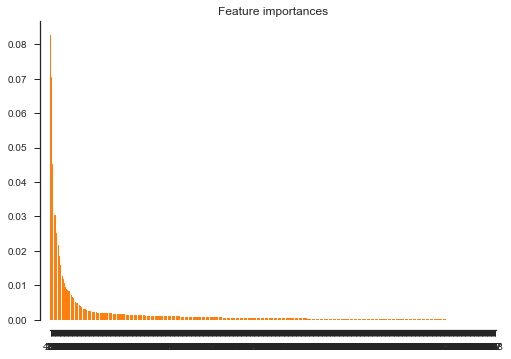

In [173]:
forest = RandomForestRegressor(n_estimators=50, random_state=0, n_jobs=-1)
forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
sns.despine(offset=10)

In [202]:
def n_features_to_importances(k, importances, min_increment=0.0001):
    threshold = 0
    n_features = importances.size
    while n_features > k:
        threshold += min_increment
        n_features = np.count_nonzero(importances >= threshold)
        
    return threshold

In [205]:
memory = Memory(cachedir='/home/glemaitre/cache', verbose=0)
cv = KFold(shuffle=True, random_state=0)
pipeline = Pipeline(memory=memory,
                        steps=[('selectfrommodel', SelectFromModel(
                            RandomForestRegressor(n_estimators=50,
                            n_jobs=-1,
                            random_state=0))),
                               ('clf', RandomForestRegressor(n_estimators=50,
                                                             n_jobs=-1,
                                                             random_state=0))])

n_features = np.arange(10, X.shape[1], 5)
thresholds = [n_features_to_importances(k, importances) for k in n_features]

results_r2 = np.zeros((10, len(thresholds)))
results_mae = np.zeros((10, len(thresholds)))
for n_try in range(10):
    for threshold_index, threshold in enumerate(thresholds):
        pipeline.set_params(selectfrommodel__threshold=threshold)
        y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True, random_state=n_try))
        results_r2[n_try, threshold_index] = r2_score(y, y_pred)
        results_mae[n_try, threshold_index] = median_absolute_error(y, y_pred)

(6.5, 8.0)

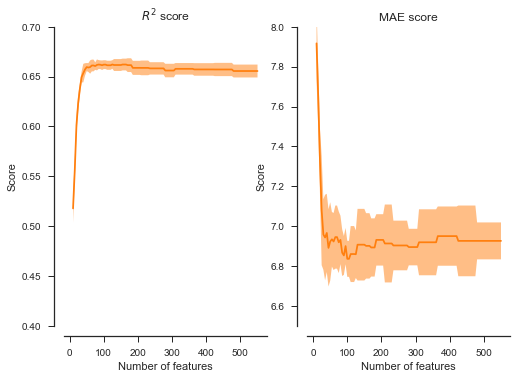

In [220]:
mean_r2 = np.mean(results_r2, axis=0)
mean_mae = np.mean(results_mae, axis=0)
std_r2 = np.std(results_r2, axis=0)
std_mae = np.std(results_mae, axis=0)

k = range(len(thresholds))

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(n_features[k], mean_r2, label=estimator_name)
ax1.fill_between(n_features[k], mean_r2 + std_r2, mean_r2 - std_r2, alpha=0.5)
ax1.set_title(r'$R^2$ score')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Score')
    
ax2.plot(n_features[k], mean_mae)
ax2.fill_between(n_features[k], mean_mae + std_mae, mean_mae - std_mae, alpha=0.5)
ax2.set_title('MAE score')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Score')
    
sns.despine(offset=10)
ax1.set_ylim([0.4, 0.7])
ax2.set_ylim([6.5, 8.])

In [218]:
print('Maximum R2 ({}) with Random Forest using a threshold of {} corresponding to {} features'.format(
    mean_r2.max(), thresholds[mean_r2.argmax()], n_features[mean_r2.argmax()]))
print('Maximum MAE ({}) with Random Forest using a threshold of {} corresponding to {} features'.format(
    mean_mae.min(), thresholds[mean_mae.argmin()], n_features[mean_mae.argmin()]))

Maximum R2 (0.6622031517439227) with Random Forest using a threshold of 0.0012000000000000003 corresponding to 125 features
Maximum MAE (6.836) with Random Forest using a threshold of 0.0014000000000000004 corresponding to 100 features


R2 score: 0.672947978128543
Median absolute deviation score: 6.719999999999999


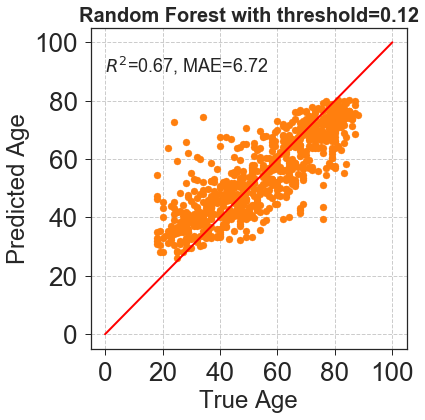

In [222]:
pipeline = make_pipeline(SelectFromModel(RandomForestRegressor(n_estimators=50, n_jobs=-1), threshold=0.0012),
                         RandomForestRegressor(n_estimators=50, n_jobs=-1))
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'Random Forest with threshold of 0.0012')

R2 score: 0.6686081421301624
Median absolute deviation score: 6.740000000000002


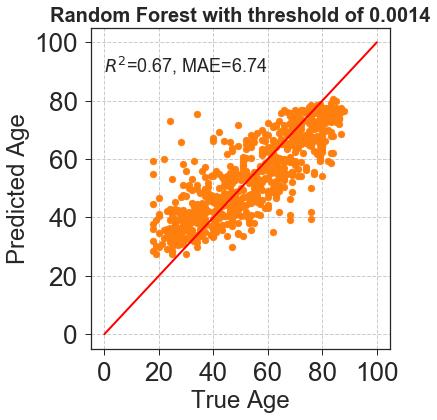

In [223]:
pipeline = make_pipeline(SelectFromModel(RandomForestRegressor(n_estimators=50, n_jobs=-1), threshold=0.0014),
                         RandomForestRegressor(n_estimators=50, n_jobs=-1))
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True,
                                                    random_state=0))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))
plot_results(y, y_pred, 'Random Forest with threshold of 0.0014')

### Analysis per experiment

This code can be used to observe the correlation between each feature in a cognitive behavioral experiment

In [154]:
experiment_name = "Hotel"
experiment_feature = load_camcan_behavioural_feature(path_exp_feat_map, experiment_name)
print('The number of features for this experiment is {}'.format(len(experiment_feature)))
dataset = load_camcan_behavioural(path_data, path_participants_info,
                                  column_selected=tuple(['Observations'] + list(experiment_feature)))

X = dataset.data
X = Imputer().fit_transform(X)
y = np.array(dataset.scores.age)
y = (np.floor(y / 10) * 10).astype(int)
X = np.hstack((X, np.atleast_2d(y).T))
X = pd.DataFrame(data=X, columns=list(experiment_feature) + ['age'])

The number of features for this experiment is 3


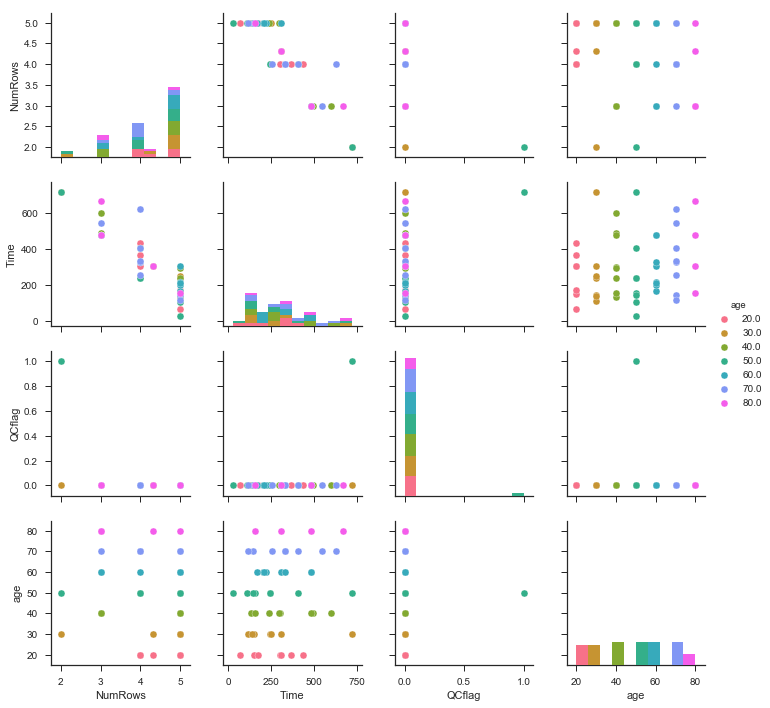

In [155]:
sns.pairplot(X.sample(50), hue='age')
plt.show()